In [5]:
from astropy.wcs import WCS
from sqlite3 import connect
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from astroquery.vizier import Vizier
import pandas as pd
import sqlite3
import numpy as np
from collections import defaultdict
from os import path
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.patches as plp
import joblib
import lamy
from matplotlib.patches import Ellipse


import Image_module as im

## Чтение fits файла, определение центра и углового размера снятого поля, загрузка каталога снимка

In [6]:
img = im.imread('test.fits') #input("Укажите название снимка или путь к нему:\n")
im_db_path = 'test.db' #input("Укажите каталог снимка или путь к нему:\n")
cat_db_path = 'catalogs.db' 
cat_name = 'sdss' #input("Выберите каталог для кросс-сопоставления: ps/sdss\n")
eps = 2 #input("Введите значение epsilon")
obs_name = 'Maidanak' #input("Выберите название обсерватории")

w = WCS(img.hdr)

field_center = SkyCoord(*w.wcs.crval, unit = [u.deg, u.deg])
region_width = img.width * (abs(w.wcs.cdelt) * u.deg).to(u.arcsec)[0]
region_height = img.height * (abs(w.wcs.cdelt) * u.deg).to(u.arcsec)[1]

# field_center: (243.9021249, 14.41539495)

In [7]:
if not path.isfile(im_db_path):
        raise IOError(f"No such file \"{im_db_path}\"")
        
con1 = sqlite3.connect(im_db_path)
df1 = pd.read_sql_query("SELECT * from objects", con1)[['ra_deg', 'ra_err', 'dec_deg', 'dec_err', 'mag', 'mag_err']]

df1.rename(columns={df1.columns[0]: 'RA1',
                    df1.columns[1]: 'e_RA1',
                    df1.columns[2]: 'DE1',
                    df1.columns[3]: 'e_DE1',
                    df1.columns[4]: 'r1',
                    df1.columns[5]: 'e_r1'}, inplace=True)

## Далее - два варианта импорта внешнего каталога:

### 1. Кросс-идентификация проводится с каталогом, хранящимся удалённо, импорт через Vizier

In [8]:
%%time

ps1 = Vizier(catalog='PanSTARRS', row_limit=-1).query_region(field_center,
                                                        width=region_width,
                                                        height=region_height)[0]

Wall time: 275 ms


### 2. Кросс-идентификация проводится с каталогом, хранящимся локально, импорт через sqlite

In [9]:
%%time

if not path.isfile(cat_db_path):
        raise IOError(f"No such file \"{cat_db_path}\"")
        
con2 = sqlite3.connect(cat_db_path)

df2 = pd.read_sql_query("SELECT * FROM {} WHERE ({} BETWEEN ? AND ?) AND ({} BETWEEN ? AND ?)".format(cat_name, cat_name + '_RA',cat_name + '_DE'),
                        con2,
                        params = [field_center.ra.value - region_width.value/7200 - 30/3600,
                                  field_center.ra.value + region_width.value/7200 + 30/3600,
                                  field_center.dec.value - region_height.value/7200 - 30/3600,
                                  field_center.dec.value + region_height.value/7200 + 30/3600])

if cat_name == 'ps':  
    
    df2.rename(columns={df2.columns[1]: 'RA2',
                        df2.columns[2]: 'e_RA2',
                        df2.columns[3]: 'DE2',
                        df2.columns[4]: 'e_DE2',
                        df2.columns[5]: 'g2',
                        df2.columns[6]: 'e_g2',
                        df2.columns[7]: 'r2',
                        df2.columns[8]: 'e_r2',
                        df2.columns[9]: 'i2',
                        df2.columns[10]: 'e_i2',
                        df2.columns[11]: 'z2',
                        df2.columns[12]: 'e_z2',
                        df2.columns[13]: 'y2',
                        df2.columns[14]: 'e_y2'}, inplace=True)
else:
    pass

if cat_name == 'sdss':
    
    df2.rename(columns={df2.columns[1]: 'RA2',
                        df2.columns[2]: 'e_RA2',
                        df2.columns[3]: 'DE2',
                        df2.columns[4]: 'e_DE2',
                        df2.columns[5]: 'u2',
                        df2.columns[6]: 'e_u2',
                        df2.columns[7]: 'g2',
                        df2.columns[8]: 'e_g2',
                        df2.columns[9]: 'r2',
                        df2.columns[10]: 'e_r2',
                        df2.columns[11]: 'i2',
                        df2.columns[12]: 'e_i2',
                        df2.columns[13]: 'z2',
                        df2.columns[14]: 'e_z2'}, inplace=True)
else:
    pass

Wall time: 564 ms


## Матчинг эпсилон-окрестностью

In [11]:
%%time
coords1 = SkyCoord(df1.iloc[:, 0].values.astype(float).tolist(), df1.iloc[:, 2].values.astype(float).tolist(), frame="icrs", unit="deg")
coords2 = SkyCoord(df2.iloc[:, 1].values.astype(float).tolist(), df2.iloc[:, 3].values.astype(float).tolist(), frame="icrs", unit="deg")

nnbs = SkyCoord.match_to_catalog_sky(coords1, coords2)

Wall time: 224 ms


## Вывод кандидатов в транзиенты

Вовсе не идентифицированные объекты (ближайший сосед находится на угловом расстоянии больше eps) - далее не рассматриваются

In [38]:
ar = nnbs[1].to(u.arcsec).value>eps
arr = 1*ar
noid = df1.iloc[np.where(arr == 1)]
noid

,RA1,e_RA1,DE1,e_DE1,r1,e_r1
21,243.748372833139,0.184556,14.3833132494563,0.185011,23.389235,0.367439
36,243.751118417503,0.183586,14.5527951890078,0.184029,22.915223,0.277863
40,243.751797352711,0.184833,14.4997544653639,0.185243,23.123242,0.310149
77,243.756057618053,0.184895,14.4827011409694,0.185305,22.482231,0.284950
78,243.756148288058,0.182906,14.4104386227962,0.183420,22.725112,0.273140
...,...,...,...,...,...,...
2230,244.026617949909,0.182779,14.5156427017122,0.183288,22.976298,0.213207
2239,244.027760037647,0.198202,14.337699886078,0.197895,24.116225,1.287425
2281,244.033709311318,0.183083,14.5186378133246,0.183555,22.289412,0.190177
2299,244.036592022755,0.192282,14.3155629997697,0.191887,22.188009,0.250940


Дубликаты

In [39]:
%%time

bb = nnbs[0][np.delete(df1.index.values, noid.index.values)] #ID объектов второго каталога,
                                                             #оказавшихся сопоставленными с объектами из первого
c1, c2 = np.unique(bb, return_counts=True) #Дубликаты
dup = c1[c2 > 1]

numbers = []

for i in dup:
    for j in np.argwhere(nnbs[0] == i).tolist():
        numbers.append(j[0])
        
duplicated = df1.iloc[numbers]
duplicated

Wall time: 998 µs


,RA1,e_RA1,DE1,e_DE1,r1,e_r1
619,243.82515147335,0.179439,14.4122964344937,0.180089,22.901880,0.173876
623,243.825649835791,0.179544,14.412493718802,0.180188,22.552554,0.142880
361,243.794200315919,0.180061,14.4935381047097,0.180677,22.755974,0.186015
362,243.794674942405,0.191633,14.4933329687505,0.191872,22.084793,0.263437
873,243.855080317053,0.186638,14.5352767804738,0.186877,22.294967,0.235892
875,243.85530682385,0.179327,14.5357914212962,0.179968,21.661318,0.108732


Для каждого объекта 1 (здесь и везде: объект 1 - объект из первого каталога (изображения) для которого ищется подходящее сопоставление (компаньон) во втором каталоге - объект 2) из пар дубликатов (одному объекту 2 оказались сопоставлены два и более объектов 1) выполняем повторный поиск в расширенном радиусе 3 угловые секунды с целью обнаружить таки компаньона: для установленных пар проводим два теста: первый тест использует указанные в каталогах ошибки локализации объектов и проверяет гипотезу о том, что пара - один и тот же объект, второй тест - обученная модель для классификации объектов по блеску. В каждом из тестов: True объекты следует сопоставить, False - сопоставление следует отклонить. Объекты, не прошедшие хотя бы один тест, зачисляются в "кандидаты в транзиенты". 

In [71]:
coords11 = SkyCoord(duplicated.iloc[:, 0].values.astype(float).tolist(), duplicated.iloc[:, 2].values.astype(float).tolist(), frame="icrs", unit="deg")

res2 = search_around_sky(coords11, coords2, seplimit=3*u.arcsec)

In [72]:
a1 = duplicated.iloc[res2[0]].copy()
a1['sep'] = res2[2].value*3600

a = df2.iloc[res2[1]]
a2 = a.copy()

a2['sep'] = res2[2].value*3600
preprod = a1.merge(a2, on='sep')
preprod

,RA1,e_RA1,DE1,e_DE1,r1,e_r1,sep,sdss_objID,RA2,e_RA2,...,u2,e_u2,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2
0,243.82515147335,0.179439,14.4122964344937,0.180089,22.901880,0.173876,1.663268,1237665567156471119,243.825598,0.129,...,23.734,1.064,22.449,0.167,21.818,0.129,21.359,0.135,21.088,0.355
1,243.825649835791,0.179544,14.412493718802,0.180188,22.552554,0.142880,0.219744,1237665567156471119,243.825598,0.129,...,23.734,1.064,22.449,0.167,21.818,0.129,21.359,0.135,21.088,0.355
2,243.794200315919,0.180061,14.4935381047097,0.180677,22.755974,0.186015,0.276676,1237665531188020719,243.794121,0.169,...,23.473,0.982,23.246,0.333,22.061,0.178,20.619,0.085,19.762,0.163
3,243.794200315919,0.180061,14.4935381047097,0.180677,22.755974,0.186015,0.094089,1237668337935582644,243.794199,0.099,...,23.671,0.837,23.895,0.387,22.610,0.240,21.053,0.092,20.243,0.153
4,243.794674942405,0.191633,14.4933329687505,0.191872,22.084793,0.263437,2.063178,1237665531188020719,243.794121,0.169,...,23.473,0.982,23.246,0.333,22.061,0.178,20.619,0.085,19.762,0.163
5,243.794674942405,0.191633,14.4933329687505,0.191872,22.084793,0.263437,1.779672,1237668337935582644,243.794199,0.099,...,23.671,0.837,23.895,0.387,22.610,0.240,21.053,0.092,20.243,0.153
6,243.855080317053,0.186638,14.5352767804738,0.186877,22.294967,0.235892,1.699893,1237665531188020485,243.855262,0.133,...,23.776,0.857,22.653,0.147,22.058,0.128,21.323,0.116,21.596,0.561
7,243.855080317053,0.186638,14.5352767804738,0.186877,22.294967,0.235892,1.799476,1237668337935647397,243.855220,0.087,...,22.868,0.497,22.465,0.136,21.513,0.100,21.557,0.160,21.241,0.411
8,243.85530682385,0.179327,14.5357914212962,0.179968,21.661318,0.108732,0.316367,1237665531188020485,243.855262,0.133,...,23.776,0.857,22.653,0.147,22.058,0.128,21.323,0.116,21.596,0.561
9,243.85530682385,0.179327,14.5357914212962,0.179968,21.661318,0.108732,0.325606,1237668337935647397,243.855220,0.087,...,22.868,0.497,22.465,0.136,21.513,0.100,21.557,0.160,21.241,0.411


Визуализация

(14.5342914212962, 14.5372914212962)

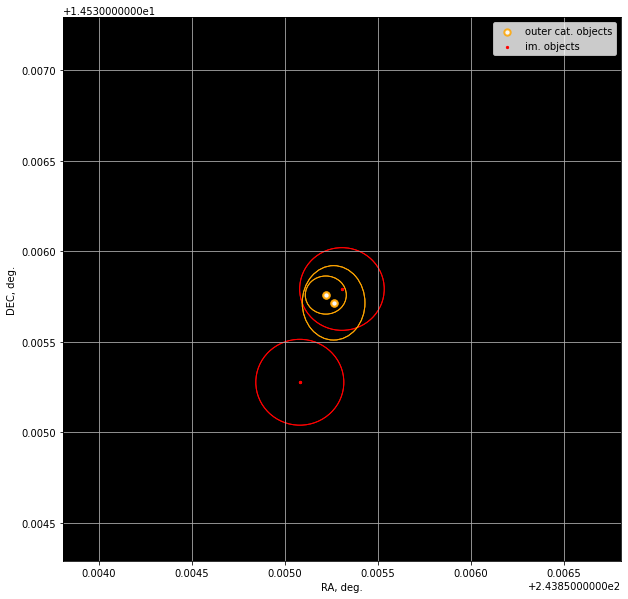

In [73]:
import scipy.stats as st

q = st.chi2(df=2).ppf(.99997)

fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(preprod['RA2'].values.astype(float), preprod['DE2'].values.astype(float), s=40, c='w', label='outer cat. objects', 
                   linewidths = 2,
                   edgecolors = 'orange',
                   alpha=0.85,)


ells1 = [Ellipse([float(preprod.iloc[i]['RA1']), float(preprod.iloc[i]['DE1'])],
                      np.sqrt(q)*float(preprod.iloc[i]['e_RA1'])/1800,
                      np.sqrt(q)*float(preprod.iloc[i]['e_DE1'])/1800,
                      fill=0,
                      edgecolor='r') for i in range(len(preprod))]


ells2 = [Ellipse([float(preprod.iloc[i]['RA2']), float(preprod.iloc[i]['DE2'])],
                      np.sqrt(q)*float(preprod.iloc[i]['e_RA2'])/1800,
                      np.sqrt(q)*float(preprod.iloc[i]['e_DE2'])/1800,
                      fill=0,
                      edgecolor='orange') for i in range(len(preprod))]

for e1 in ells1:
    ax.add_artist(e1)
    
for e2 in ells2:
    ax.add_artist(e2)

ax.scatter(preprod['RA1'].values.astype(float), preprod['DE1'].values.astype(float), s=5, color='r', label='im. objects')

ax.set_facecolor('black')
ax.set_xlabel('RA, deg.')
ax.set_ylabel('DEC, deg.')
plt.grid()
plt.legend()

# marg=0.49
# ax.margins(-marg, -marg)

loc_n = 9

ax.set_xlim(float(preprod.iloc[loc_n]['RA1'])-0.0015, float(preprod.iloc[loc_n]['RA1'])+0.0015)
ax.set_ylim(float(preprod.iloc[loc_n]['DE1'])-0.0015, float(preprod.iloc[loc_n]['DE1'])+0.0015)

In [74]:
preprod['position_test'] = preprod.apply(lamy.position_test, axis = 1, args = (0.99997, ))
preprod['photometry_test'] = preprod.apply(lamy.photometry_test, axis = 1, args = (obs_name, ))

prod = preprod.copy()
prod['tests_sum'] = 1*prod['position_test'] + 1*prod['photometry_test']

prod

,RA1,e_RA1,DE1,e_DE1,r1,e_r1,sep,sdss_objID,RA2,e_RA2,...,e_g2,r2,e_r2,i2,e_i2,z2,e_z2,position_test,photometry_test,tests_sum
0,243.82515147335,0.179439,14.4122964344937,0.180089,22.901880,0.173876,1.663268,1237665567156471119,243.825598,0.129,...,0.167,21.818,0.129,21.359,0.135,21.088,0.355,False,False,0
1,243.825649835791,0.179544,14.412493718802,0.180188,22.552554,0.142880,0.219744,1237665567156471119,243.825598,0.129,...,0.167,21.818,0.129,21.359,0.135,21.088,0.355,True,False,1
2,243.794200315919,0.180061,14.4935381047097,0.180677,22.755974,0.186015,0.276676,1237665531188020719,243.794121,0.169,...,0.333,22.061,0.178,20.619,0.085,19.762,0.163,True,True,2
3,243.794200315919,0.180061,14.4935381047097,0.180677,22.755974,0.186015,0.094089,1237668337935582644,243.794199,0.099,...,0.387,22.610,0.240,21.053,0.092,20.243,0.153,True,False,1
4,243.794674942405,0.191633,14.4933329687505,0.191872,22.084793,0.263437,2.063178,1237665531188020719,243.794121,0.169,...,0.333,22.061,0.178,20.619,0.085,19.762,0.163,False,False,0
5,243.794674942405,0.191633,14.4933329687505,0.191872,22.084793,0.263437,1.779672,1237668337935582644,243.794199,0.099,...,0.387,22.610,0.240,21.053,0.092,20.243,0.153,False,False,0
6,243.855080317053,0.186638,14.5352767804738,0.186877,22.294967,0.235892,1.699893,1237665531188020485,243.855262,0.133,...,0.147,22.058,0.128,21.323,0.116,21.596,0.561,False,False,0
7,243.855080317053,0.186638,14.5352767804738,0.186877,22.294967,0.235892,1.799476,1237668337935647397,243.855220,0.087,...,0.136,21.513,0.100,21.557,0.160,21.241,0.411,False,False,0
8,243.85530682385,0.179327,14.5357914212962,0.179968,21.661318,0.108732,0.316367,1237665531188020485,243.855262,0.133,...,0.147,22.058,0.128,21.323,0.116,21.596,0.561,True,True,2
9,243.85530682385,0.179327,14.5357914212962,0.179968,21.661318,0.108732,0.325606,1237668337935647397,243.855220,0.087,...,0.136,21.513,0.100,21.557,0.160,21.241,0.411,True,True,2


Достаём кандидатов из исходной таблицы

In [75]:
ra = prod.groupby(['RA1'], sort=False)['tests_sum'].max()

candidates = df1.loc[df1['RA1'].astype(float).isin(np.array(ra.loc[ra<2].index, dtype=float).tolist())] 
candidates

,RA1,e_RA1,DE1,e_DE1,r1,e_r1
362,243.794674942405,0.191633,14.4933329687505,0.191872,22.084793,0.263437
619,243.82515147335,0.179439,14.4122964344937,0.180089,22.901880,0.173876
623,243.825649835791,0.179544,14.412493718802,0.180188,22.552554,0.142880
873,243.855080317053,0.186638,14.5352767804738,0.186877,22.294967,0.235892
